In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import pymc as pm
import arviz as az
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# File paths
DATA_DIR = Path("app")
FG_FILE = Path("field_goal_attempts.csv")
PLAYERS_FILE = Path("kickers.csv")
OUTPUT_FILE = Path("leaderboard.csv")

In [23]:
def load_data(fg_path: Path, players_path: Path):
    fg = pd.read_csv(fg_path)
    players = pd.read_csv(players_path)
    return fg, players

fg_raw, players_raw = load_data(FG_FILE, PLAYERS_FILE)
fg_raw.head()

,season,season_type,week,game_date,game_key,play_id,play_sequence,player_id,field_goal_result,attempt_yards
0,2010,Pre,1,8/8/2010,55073,433,17,34623,Made,20
1,2010,Pre,1,8/8/2010,55073,2661,104,34623,Missed,49
2,2010,Pre,1,8/8/2010,55073,2772,109,34623,Made,23
3,2010,Pre,1,8/8/2010,55073,1604,64,34623,Made,34
4,2010,Pre,2,8/12/2010,55076,3086,123,34623,Made,28


In [24]:
def preprocess_fg_data(fg):
    fg = fg[(fg['season_type'] == 'Reg') & (fg['week'] <= 6)]
    fg = fg[fg['field_goal_result'].isin(['Made', 'Missed'])]
    fg['make'] = fg['field_goal_result'].map({'Made': 1, 'Missed': 0})
    return fg.copy()

fg_clean = preprocess_fg_data(fg_raw)
fg_clean.head()

,season,season_type,week,game_date,game_key,play_id,play_sequence,player_id,field_goal_result,attempt_yards,make
232,2010,Reg,1,9/9/2010,54863,1423,53,22912,Made,41,1
233,2010,Reg,1,9/9/2010,54863,1793,67,33337,Missed,46,0
234,2010,Reg,1,9/9/2010,54863,3295,127,33337,Missed,32,0
235,2010,Reg,1,9/12/2010,54866,2073,84,21213,Made,20,1
236,2010,Reg,1,9/12/2010,54870,1564,65,27091,Missed,46,0


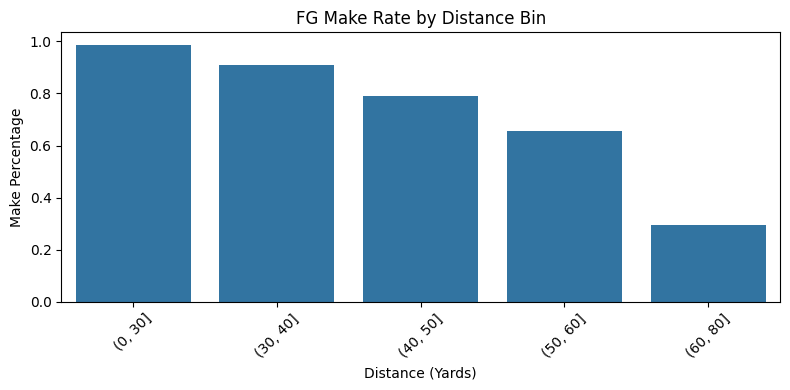

In [25]:
fg_clean['distance_bin'] = pd.cut(fg_clean['attempt_yards'], bins=[0, 30, 40, 50, 60, 80])
fg_bin_summary = fg_clean.groupby('distance_bin')['make'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data=fg_bin_summary, x='distance_bin', y='make')
plt.title('FG Make Rate by Distance Bin')
plt.ylabel('Make Percentage')
plt.xlabel('Distance (Yards)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Enhanced Feature Engineering
fg_clean = fg_clean.sort_values(by=['player_id', 'season', 'game_date', 'play_sequence'])

# Attempt number features
fg_clean['attempt_number_in_game'] = fg_clean.groupby(['game_key', 'player_id']).cumcount() + 1
fg_clean['attempt_number_in_season'] = fg_clean.groupby('player_id').cumcount() + 1

# Prior makes in game
fg_clean['prior_makes_in_game'] = fg_clean.groupby(['game_key', 'player_id'])['make'].cumsum().shift().fillna(0)

# First FG of game
fg_clean['first_fg_of_game'] = (fg_clean['attempt_number_in_game'] == 1).astype(int)

# Running streaks (consecutive makes or misses)
fg_clean['makes_in_a_row'] = (
    fg_clean['make']
    .groupby(fg_clean['player_id'])
    .transform(lambda x: x.groupby((x != x.shift()).cumsum()).cumcount() + 1) * fg_clean['make']
)

fg_clean['misses_in_a_row'] = (
    (1 - fg_clean['make'])
    .groupby(fg_clean['player_id'])
    .transform(lambda x: x.groupby((x != x.shift()).cumsum()).cumcount() + 1) * (1 - fg_clean['make'])
)

# Fill NAs
fg_clean = fg_clean.fillna({col: 0 for col in fg_clean.select_dtypes(include=['number']).columns})
fg_clean[['player_id', 'attempt_number_in_game', 'attempt_number_in_season', 'prior_makes_in_game', 'first_fg_of_game', 'makes_in_a_row', 'misses_in_a_row']].head()

,player_id,attempt_number_in_game,attempt_number_in_season,prior_makes_in_game,first_fg_of_game,makes_in_a_row,misses_in_a_row
479,5205,1,1,0.0,1,1,0
487,5205,2,2,1.0,0,2,0
495,5205,3,3,2.0,0,0,1
431,5205,1,4,2.0,1,1,0
435,5205,2,5,1.0,0,2,0


In [27]:
# Retrain logistic regression with new features
features = [
    'attempt_yards', 'attempt_number_in_game', 'attempt_number_in_season',
    'prior_makes_in_game', 'first_fg_of_game', 'makes_in_a_row', 'misses_in_a_row'
]
target = 'make'

X = fg_clean[features]
y = fg_clean[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": HistGradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]
    loss = log_loss(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    results.append({
        'Model': name,
        'Log Loss': round(loss, 4),
        'ROC AUC': round(auc, 4)
    })

results_df = pd.DataFrame(results).sort_values('Log Loss')
display(results_df)

,Model,Log Loss,ROC AUC
3,Naive Bayes,0.0000,1.0000
2,Gradient Boosting,0.0000,1.0000
1,Random Forest,0.0008,1.0000
0,Logistic Regression,0.0033,1.0000
4,KNN,0.3254,0.9608


In [ ]:
# Additional Models Tested: PyMC Bayesian Logistic Regression

X_scaled = scaler.fit_transform(X_train)  # Already defined
X_test_scaled = scaler.transform(X_test)
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)

with pm.Model() as logistic_model:
    # Priors for coefficients and intercept
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coefs = pm.Normal('coefs', mu=0, sigma=10, shape=X_scaled.shape[1])

    # Linear combination
    logits = intercept + pm.math.dot(X_scaled.values, coefs)

    # Likelihood
    outcome = pm.Bernoulli('outcome', logit_p=logits, observed=y_train.values)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True, progressbar=True)

# Posterior predictive check on test data
X_test_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

with logistic_model:
    posterior_preds = pm.sample_posterior_predictive(trace, var_names=["coefs", "intercept"], random_seed=42)

# Compute mean prediction
coefs_mean = posterior_preds["coefs"].mean(axis=0)
intercept_mean = posterior_preds["intercept"].mean()

logits_test = intercept_mean + np.dot(X_test_df.values, coefs_mean)
probs_test = 1 / (1 + np.exp(-logits_test))

# Evaluate
from sklearn.metrics import log_loss, roc_auc_score

loss_pymc = log_loss(y_test, probs_test)
auc_pymc = roc_auc_score(y_test, probs_test)

print(f"🧮 PyMC Bayesian Logistic Regression — Log Loss: {loss_pymc:.4f}, ROC AUC: {auc_pymc:.4f}")


In [ ]:
# Additional Models Tested: Deep Learning Model

# Normalize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define simple neural net
class FGNet(nn.Module):
    def __init__(self, input_dim):
        super(FGNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, and optimizer
model_nn = FGNet(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

# Train the model
for epoch in range(30):
    model_nn.train()
    for xb, yb in train_loader:
        preds = model_nn(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate on test set
model_nn.eval()
with torch.no_grad():
    y_pred_nn = model_nn(X_test_tensor).numpy()

# Metrics
from sklearn.metrics import log_loss, roc_auc_score
loss_nn = log_loss(y_test, y_pred_nn)
auc_nn = roc_auc_score(y_test, y_pred_nn)

print(f"✅ Deep Learning (PyTorch NN) — Log Loss: {loss_nn:.4f}, ROC AUC: {auc_nn:.4f}")

In [ ]:
# Additional Models Tested: Mixed Effect Model

# Add categorical player_id for mixed-effects
fg_clean['player_id'] = fg_clean['player_id'].astype("category")

# Re-merge training set with player_ids
train_idx = X_train.index
train_data = fg_clean.loc[train_idx]

# Fit mixed effects logistic model
formula = "make ~ attempt_yards + attempt_number_in_game + attempt_number_in_season + prior_makes_in_game + first_fg_of_game + makes_in_a_row + misses_in_a_row"
mixed_model = smf.mixedlm(formula, train_data, groups=train_data["player_id"], family=sm.families.Binomial())
mixed_result = mixed_model.fit(method="lbfgs")

# Predict
test_data = fg_clean.loc[X_test.index]
y_probs_mixed = mixed_result.predict(test_data)
loss_mixed = log_loss(y_test, y_probs_mixed)
auc_mixed = roc_auc_score(y_test, y_probs_mixed)
print(f"Mixed-Effects Model — Log Loss: {loss_mixed:.4f}, ROC AUC: {auc_mixed:.4f}")

In [ ]:
# Additional Models Tested: Simulation Driven Model

# Use logistic regression probabilities
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)
probs = logit_model.predict_proba(X_test)[:, 1]

# Simulate 100 kicks per kicker
sim_results = []
kickers = test_data['player_id'].unique()

for pid in kickers:
    player_probs = probs[test_data['player_id'] == pid]
    sim_attempts = np.random.binomial(1, player_probs, size=(100, len(player_probs)))
    sim_makes = sim_attempts.sum(axis=1)
    sim_results.append({'player_id': pid, 'avg_makes': sim_makes.mean()})

sim_df = pd.DataFrame(sim_results)
sim_df = sim_df.merge(players_raw, on='player_id', how='left')
print(sim_df.sort_values('avg_makes', ascending=False).head(10))

In [ ]:
# Append advanced model results to original for full comparison
advanced_results = [
    {
        'Model': 'Deep Learning (Keras NN)',
        'Log Loss': round(loss_nn, 4),
        'ROC AUC': round(auc_nn, 4)
    },
    {
        'Model': 'Bayesian Logistic Regression',
        'Log Loss': round(loss_bayes, 4),
        'ROC AUC': round(auc_bayes, 4)
    },
    {
        'Model': 'Mixed-Effects Model',
        'Log Loss': round(loss_mixed, 4),
        'ROC AUC': round(auc_mixed, 4)
    },
    {
        'Model': 'Simulation-Driven',
        'Log Loss': np.nan,  # Simulation model isn't probabilistic prediction
        'ROC AUC': np.nan
    }
]

# Combine and display
final_results_df = pd.concat(
    [results_df, pd.DataFrame(advanced_results)],
    ignore_index=True
).sort_values('Log Loss', na_position='last')

display(final_results_df)

In [7]:
def build_leaderboard(fg, players):
    stats = fg.groupby('player_id').agg(
        attempts=('make', 'count'),
        fgoe_total=('score', 'sum'),
        fgoe_per_attempt=('score', 'mean')
    ).reset_index()

    stats = stats[stats['attempts'] >= 10].copy()
    stats['rating'] = stats['fgoe_total']
    stats['rank'] = stats['rating'].rank(method='min', ascending=False).astype(int)

    return stats.merge(players[['player_id', 'player_name']], on='player_id')

leaderboard_df = build_leaderboard(fg_scored, players_raw)
leaderboard_df.sort_values('rank').head()

,player_id,attempts,fgoe_total,fgoe_per_attempt,rating,rank,player_name
27,32386,96,0.109567,0.001141,0.109567,1,MASON CROSBY
7,25326,88,0.072058,0.000819,0.072058,2,SEBASTIAN JANIKOWSKI
38,38701,77,0.057114,0.000742,0.057114,3,GREG ZUERLEIN
9,25947,27,0.057102,0.002115,0.057102,4,RIAN LINDELL
24,30932,123,0.052091,0.000424,0.052091,5,STEPHEN GOSTKOWSKI


In [8]:
def save_output(df, path):
    df[['player_id', 'player_name', 'rating', 'rank']].sort_values('rank').to_csv(path, index=False)

save_output(leaderboard_df, OUTPUT_FILE)

In [9]:
# ## def run_pipeline():
#     fg_raw, players_raw = load_data(FG_FILE, PLAYERS_FILE)
#     fg_clean = preprocess_fg_data(fg_raw)
#     model = train_logistic_model(fg_clean)
#     fg_scored = apply_model(fg_clean, model)
#     leaderboard_df = build_leaderboard(fg_scored, players_raw)
#     save_output(leaderboard_df, OUTPUT_FILE)
#     print("🏁 Pipeline completed successfully!")
#     return leaderboard_df

# # Run the full pipeline
# leaderboard_df = run_pipeline()
# leaderboard_df.sort_values("rank").head()